"Empower Your Science with Real-Time Visual Insights: See, Decide, Act"

The following code is part of **Monica** (**Moni**toring, **C**ontrol, and **A**utomation), a Python-based toolset designed for real-time monitoring, control, and automation of syngas-fermenting reactors. **Monica** is a Syn2Value early spin-off, enhancing reactor management through advanced data analytics and interactive visualizations.


This specific chunk of code is developed to share the enrichment experiments of the Syn2Value work package 1. It processes CSV data previously curated from multiple Google Sheets files (further details can be found in the DataAnalysis-25Jun24.ipynb notebook). The algorithm presented here integrates this data to generate a fully interactive plot, offering users comprehensive control over the visualization parameters and insights they wish to explore.

Version: Beta 1.1207

---

# Introduction
We set up an enrichment experiment with the factors and levels shown in Table 1. We started with an inoculum prepared from 4 sources: anaerobic thermophilic sludge, anaerobic mesophilic sludge (20220126-s-Hertogenbosch-212-2ul, 20220126-Elburg-1a1-2ul), sediments from a WUR campus pond (next to Helix building). Temperature of incubation was controlled at 55 °C.
For the second batch (or transfer), 1mL from each bottle (3 mL per new bottle) wer transfered as inoculum. The gas composition for experiments with CO changed to 52%:16%:32%, i.e., the CO concentration in those bottles was doubled. The rest of conditions remained without changes.

All experiments were done by triplicate. We also included a set of control bottles to account for pottential physicochemical/abiotical changes, if any.


### Table 1. Experimental description
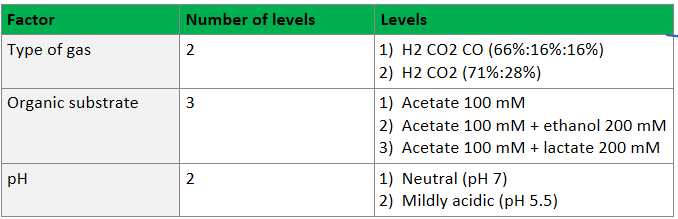

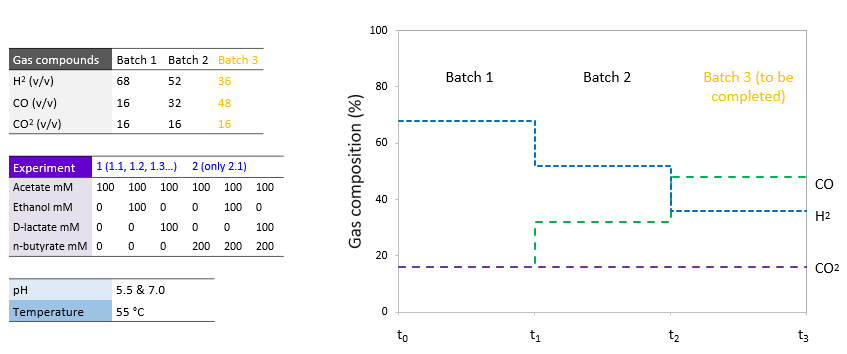

The plots shown further down are interactive plots that get updated automatically. You will have the option to pick the following:

Database: there are two (1st and 2nd batch), which collect the data from their respective phases of the experiment (i.e., 1st and 2nd transfers)


Select variable 1 and 2: choose the explanatory variables consider in this experiment for filtering the database and deploy a cleaner plot. Once you choose among the explanatory variables available (pH init, gas phase, and liquid substrate), you will have the option to select which subgroup within such variables you want to keep. For instance, if you choose Initial pH, you could further choose the pH value 5.5 to keep only the datapoints with such initial pH. Same with the second variable. When you choose the second variable the database is filter by the two variables, so the cleaner it will look.

Color: Furthermore, you can select the remaining explanatory variable to distinguished the datapoints based on such variable. This will be displayed on the plot as a color scale.


# 1. Required dependencies

In [13]:
%%capture
!wget -O requirements.txt https://raw.githubusercontent.com/RodolfoPalomo/monica_public/main/requirements.txt
!pip install -r requirements.txt

In [14]:
%%capture
# Import packages and dependencies as needed
#IPython
import kaleido
import IPython
from IPython import get_ipython
from IPython.display import display, clear_output

#Google Drive access
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import gdown

#Data management
import pandas as pd
import numpy as np

#Plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots

#IPyWidgets
import ipywidgets as widgets
from ipywidgets import interact, widgets, interactive_output

# 2. Load database

In [24]:
%%capture
# URL of the CSV file on Google Drive
file_url1 = 'https://drive.google.com/uc?id=1-3ScmJpK3AhfC45IlCffs8gEfT1a0ocB&export=download'
file_url2 = 'https://drive.google.com/uc?id=1-28xmG8pdcE6JMvp-KsMoqXlUJDyQyDU&export=download'

# Load the CSV file into a DataFrame
Exp1_db1 = pd.read_csv(file_url1)
Exp1_db2 = pd.read_csv(file_url2)

# Display the first few rows of the DataFrame
Exp1_db1.info(), Exp1_db2.info()
# Load the CSV file into a DataFrame
#Exp1_db = pd.read_csv(output)

# Display the DataFrame
#print(Exp1_db)

# 3. Plots

## Widgets prep

In [25]:
%%capture
#Variables for dropdown menus
x_variables= [
    "Liquid substrates",
    "Gas mixture",
    "Initial pH",
    "Elapsed time (days)",
    "Gas volume (STD mL)",
    #"Gas production/consumption (STD mL)",
    "pH",
    "Optical density 600nm (abs)",
    "H2 volume (STD mL)",
    "CO volume (STD mL)",
    "CO2 volume (STD mL)",
    "Cumulative gas production/consumption (STD mL)",
    "Cumulative H2 production/consumption (STD mL)",
    "Cumulative CO production/consumption (STD mL)",
    "Cumulative CO2 production/consumption (STD mL)"
]
y_variables= [
    "Gas volume (STD mL)",
    #"Gas production/consumption (STD mL)",
    "pH",
    "Optical density 600nm (abs)",
    "H2 (STD mL)",
    "CO (STD mL)",
    "CO2 (STD mL)",
    "H2 (mol)",
    "CO (mol)",
    "CO2 (mol)",                                       
    "Methanol (mM)",
    "Formate (mM)",
    "Ethanol (mM)",
    "Acetate (mM)",
    "Propanol (mM)",
    "Propionate (mM)",
    "Lactate (mM)",
    "Iso-butyrate (mM)",
    "n-Butyrate (mM)",
    "Iso-valerate (mM)",
    "n-Valerate (mM)",
    "n-Caproate (mM)"
]
color_variables = [
    "Liquid substrates",
    "Gas mixture",
    "Initial pH"]
facet_variables= color_variables

bar_variables=["Methanol (mM)",
    "Formate (mM)",
    "Ethanol (mM)",
    "Acetate (mM)",
    "Propanol (mM)",
    "Propionate (mM)",
    "Lactate (mM)",
    "Iso-butyrate (mM)",
    "n-Butyrate (mM)",
    "Iso-valerate (mM)",
    "n-Valerate (mM)",
    "n-Caproate (mM)"]


## Plot all points
This one shows all points explicitly. You will see what the variation was among triplicates. Still, the error bars wont be shown on this Monica's version. See Monica's website/group to see what's coming next. 

In [22]:
pio.renderers.default = 'iframe'
# Dropdown for selecting the database
db_selection_dropdown = widgets.Dropdown(
    options={'1st Batch': 'Exp1_db1', '2nd Batch': 'Exp1_db2'},
    value='Exp1_db1',
    description='Select Database:'
)

# Output widget to confirm the selected database
db_output = widgets.Output()

def on_db_change(change):
    with db_output:
        db_output.clear_output()
        selected_db_name = change['new']
        global Exp1_db
        Exp1_db = globals()[selected_db_name]
        print(f"Selected Database: {selected_db_name}")
        # Update dropdown options and plot when database changes
        update_dropdown_options({'owner': None, 'new': None})  # Reset dropdown options
        update_plot()  # Update the plot with new data

# Link the dropdown change to the function
db_selection_dropdown.observe(on_db_change, names='value')

# Initial assignment
Exp1_db = globals()[db_selection_dropdown.value]

# Columns the user can choose to filter the db (replace with your actual data)
column_options = ['Initial pH', 'Liquid substrates', 'Gas mixture']

# Dropdowns for selecting columns and their corresponding values
filter_dropdown_1 = widgets.Dropdown(options=[None] + column_options, description='Select variable 1:')
filter_dropdown_1b = widgets.Dropdown(description='Group within variable 1:')
filter_dropdown_2 = widgets.Dropdown(options=[None] + column_options, description='Select variable 2:')
filter_dropdown_2b = widgets.Dropdown(description='Group within variable 2:')

# Dropdown for selecting color mapping variable
color_dropdown = widgets.Dropdown(options=[None] + column_options, description='Color:')

# Dropdown for selecting response variable
response_dropdown = widgets.Dropdown(options=list(y_variables), description='Y var:')

# Dropdown for selecting trendline type
trendline_dropdown = widgets.Dropdown(
    options=[None, 'Linear', 'Locally weighted (lowess)', 'Expanding', 'Rolling'],
    description='Trendline:'
)

# Slider for LOWESS 'frac' parameter (default range: 0.01 to 1)
lowess_frac_slider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=1.0,
    step=0.01,
    description='LOWESS Frac:',
    continuous_update=False
)

# Slider for Rolling 'window' parameter (default range: 2 to 10)
rolling_window_slider = widgets.IntSlider(
    value=3,
    min=2,
    max=10,
    step=1,
    description='Rolling Window:',
    continuous_update=False
)

# Function to show/hide the LOWESS frac slider and Rolling window slider based on trendline selection
def on_trendline_change(change):
    if change['new'] == 'Locally weighted (lowess)':
        lowess_frac_slider.layout.visibility = 'visible'
        rolling_window_slider.layout.visibility = 'hidden'
    elif change['new'] == 'Rolling':
        lowess_frac_slider.layout.visibility = 'hidden'
        rolling_window_slider.layout.visibility = 'visible'
    else:
        lowess_frac_slider.layout.visibility = 'hidden'
        rolling_window_slider.layout.visibility = 'hidden'

# Link the trendline dropdown change to the show/hide function
trendline_dropdown.observe(on_trendline_change, names='value')

# Initially hide both LOWESS frac slider and Rolling window slider
lowess_frac_slider.layout.visibility = 'hidden'
rolling_window_slider.layout.visibility = 'hidden'

# Output widget for displaying the plot
output = widgets.Output()

# Function to update the options of the dropdowns based on selected columns
def update_dropdown_options(change):
    selected_variables = {filter_dropdown_1.value, filter_dropdown_2.value}
    remaining_columns = list(set(column_options) - selected_variables)

    if change['owner'] == filter_dropdown_1:
        selected_column = change['new']
        if selected_column:
            unique_values = Exp1_db[selected_column].unique()
            filter_dropdown_1b.options = [None] + list(unique_values)
    elif change['owner'] == filter_dropdown_1b:
        pass  # No need to update the main dropdown from the subset dropdown

    elif change['owner'] == filter_dropdown_2:
        selected_column = change['new']
        if selected_column:
            unique_values = Exp1_db[selected_column].unique()
            filter_dropdown_2b.options = [None] + list(unique_values)
    elif change['owner'] == filter_dropdown_2b:
        pass  # No need to update the main dropdown from the subset dropdown

    color_dropdown.options = ['None'] + remaining_columns

    # Update plot based on current dropdown values
    update_plot()

# Link dropdowns to update function
filter_dropdown_1.observe(update_dropdown_options, names='value')
filter_dropdown_1b.observe(update_dropdown_options, names='value')
filter_dropdown_2.observe(update_dropdown_options, names='value')
filter_dropdown_2b.observe(update_dropdown_options, names='value')
color_dropdown.observe(update_dropdown_options, names='value')
response_dropdown.observe(update_dropdown_options, names='value')
trendline_dropdown.observe(update_dropdown_options, names='value')
lowess_frac_slider.observe(update_dropdown_options, names='value')
rolling_window_slider.observe(update_dropdown_options, names='value')

# Function to update the plot based on selected options
def update_plot():
    with output:
        clear_output(wait=True)
        # Apply filters to the dataset based on dropdown selections
        filtered_data = Exp1_db.copy()

        if filter_dropdown_1.value and filter_dropdown_1b.value:
            filtered_data = filtered_data[filtered_data[filter_dropdown_1.value] == filter_dropdown_1b.value]
        if filter_dropdown_2.value and filter_dropdown_2b.value:
            filtered_data = filtered_data[filtered_data[filter_dropdown_2.value] == filter_dropdown_2b.value]

        # Filter out rows with NaN or infinite values in relevant columns
        filtered_data = filtered_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['Elapsed time (days)', response_dropdown.value])

        # Define the trendline options
        trendline_options = {}
        # Map 'linear' to 'ols'
        trendline = trendline_dropdown.value
        if trendline == 'Linear': trendline = 'ols'
        if trendline == 'Locally weighted (lowess)':
            trendline = 'lowess'
            trendline_options = {'trendline_options': dict(frac=lowess_frac_slider.value)}
        if trendline == 'Expanding': trendline = 'expanding'
        if trendline == 'Rolling':
            trendline = 'rolling'
            trendline_options = {'trendline_options': dict(window=rolling_window_slider.value)}

        # Plotting with Plotly Express
        fig = px.scatter(
            filtered_data,
            x='Elapsed time (days)',
            y=response_dropdown.value,
            color=color_dropdown.value if color_dropdown.value != 'None' else None,
            title=f'Scatter Plot: {response_dropdown.value} vs Elapsed time (days)',
            trendline=trendline,
            **trendline_options
        )

        # Additional layout and styling options
        fig.update_layout(template="simple_white")
        fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', mirror=True, range=[0, None])
        # Customize marker size and type
        fig.update_traces(marker=dict(size=12, symbol='square'), line=dict(dash='dash', color="#808080"))

        # Display the plot
        fig.show()

# Call update_plot initially to display initial state
update_plot()

# Arrange the widgets in a vertical box layout
upper_box = widgets.HBox([filter_dropdown_1, filter_dropdown_1b, filter_dropdown_2, filter_dropdown_2b])
lower_box = widgets.HBox([response_dropdown, color_dropdown, trendline_dropdown])
ui = widgets.VBox([db_selection_dropdown, db_output, upper_box, lower_box, lowess_frac_slider, rolling_window_slider])

# Display the UI and initial plot together in a browser tab
display(ui, output)

Output()

## Summary plot
The aim here is to show summarized data, i.e., average values

In [10]:
pio.renderers.default = 'iframe'
# Dropdown for selecting the database
db_selection_dropdown = widgets.Dropdown(
    options={'1st Batch': 'Exp1_db1', '2nd Batch': 'Exp1_db2'},
    value='Exp1_db1',
    description='Select Database:'
)

# Output widget to confirm the selected database
db_output = widgets.Output()

def on_db_change(change):
    with db_output:
        db_output.clear_output()

        selected_db_name = change['new']
        global Exp1_db
        Exp1_db = globals()[selected_db_name]
        print(f"Selected Database: {selected_db_name}")
        # Update dropdown options and plot when database changes
        update_dropdown_options({'owner': None, 'new': None})  # Reset dropdown options
        update_summary_plot()  # Update the plot with new data

# Link the dropdown change to the function
db_selection_dropdown.observe(on_db_change, names='value')

# Initial assignment
Exp1_db = globals()[db_selection_dropdown.value]

# Columns the user can choose to filter the db (replace with your actual data)
column_options = ['Initial pH', 'Liquid substrates', 'Gas mixture']

# Dropdowns for selecting columns and their corresponding values
filter_dropdown_1 = widgets.Dropdown(options=[None] + column_options, description='Select variable 1:')
filter_dropdown_1b = widgets.Dropdown(description='Group within variable 1:')
filter_dropdown_2 = widgets.Dropdown(options=[None] + column_options, description='Select variable 2:')
filter_dropdown_2b = widgets.Dropdown(description='Group within variable 2:')

# Dropdown for selecting color mapping variable
color_dropdown = widgets.Dropdown(options=[None] + column_options, description='Color:')

# Dropdown for selecting response variable
response_dropdown = widgets.Dropdown(options=list(y_variables), description='Y var:')

# Dropdown for selecting trendline type
trendline_dropdown = widgets.Dropdown(
    options=[None, 'Linear', 'Locally weighted (lowess)', 'Expanding', 'Rolling'],
    description='Trendline:'
)

# Slider for LOWESS 'frac' parameter (default range: 0.01 to 1)
lowess_frac_slider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=1.0,
    step=0.01,
    description='LOWESS Frac:',
    continuous_update=False
)

# Slider for Rolling 'window' parameter (default range: 2 to 10)
rolling_window_slider = widgets.IntSlider(
    value=3,
    min=2,
    max=10,
    step=1,
    description='Rolling Window:',
    continuous_update=False
)

# Output widgets for displaying plots
summary_output = widgets.Output()

# Function to update the options of the dropdowns based on selected columns
def update_dropdown_options(change):
    selected_variables = {filter_dropdown_1.value, filter_dropdown_2.value}
    remaining_columns = list(set(column_options) - selected_variables)

    if change['owner'] == filter_dropdown_1:
        selected_column = change['new']
        if selected_column:
            unique_values = Exp1_db[selected_column].unique()
            filter_dropdown_1b.options = [None] + list(unique_values)
    elif change['owner'] == filter_dropdown_1b:
        pass  # No need to update the main dropdown from the subset dropdown

    elif change['owner'] == filter_dropdown_2:
        selected_column = change['new']
        if selected_column:
            unique_values = Exp1_db[selected_column].unique()
            filter_dropdown_2b.options = [None] + list(unique_values)
    elif change['owner'] == filter_dropdown_2b:
        pass  # No need to update the main dropdown from the subset dropdown

    color_dropdown.options = [None] + remaining_columns

    # Update plots based on current dropdown values
    update_summary_plot()

# Link dropdowns to update function
filter_dropdown_1.observe(update_dropdown_options, names='value')
filter_dropdown_1b.observe(update_dropdown_options, names='value')
filter_dropdown_2.observe(update_dropdown_options, names='value')
filter_dropdown_2b.observe(update_dropdown_options, names='value')
color_dropdown.observe(update_dropdown_options, names='value')
response_dropdown.observe(update_dropdown_options, names='value')
trendline_dropdown.observe(update_dropdown_options, names='value')
lowess_frac_slider.observe(update_dropdown_options, names='value')
rolling_window_slider.observe(update_dropdown_options, names='value')

# Function to show/hide the LOWESS frac slider and Rolling window slider based on trendline selection
def on_trendline_change(change):
    if change['new'] == 'Locally weighted (lowess)':
        lowess_frac_slider.layout.visibility = 'visible'
        rolling_window_slider.layout.visibility = 'hidden'
    elif change['new'] == 'Rolling':
        lowess_frac_slider.layout.visibility = 'hidden'
        rolling_window_slider.layout.visibility = 'visible'
    else:
        lowess_frac_slider.layout.visibility = 'hidden'
        rolling_window_slider.layout.visibility = 'hidden'

# Link the trendline dropdown change to the show/hide function
trendline_dropdown.observe(on_trendline_change, names='value')

# Initially hide both LOWESS frac slider and Rolling window slider
lowess_frac_slider.layout.visibility = 'hidden'
rolling_window_slider.layout.visibility = 'hidden'


# Function to update the summary plot based on selected options
def update_summary_plot():
    with summary_output:
        clear_output(wait=True)

        # Summary data processing
        summary_data = Exp1_db.copy()

        # Determine the columns to keep: float columns and the user-selected columns
        float_columns = summary_data.select_dtypes(include='float').columns

        # Determine the selected columns, ensuring 'None' values are excluded
        selected_columns = {
            filter_dropdown_1.value if filter_dropdown_1.value and filter_dropdown_1.value != "None" else None,
            filter_dropdown_2.value if filter_dropdown_2.value and filter_dropdown_2.value != "None" else None,
            color_dropdown.value if color_dropdown.value and color_dropdown.value != "None" else None,
            'Elapsed time (days)'
        } - {None}

        # Combine float columns and selected columns to determine the columns to keep
        columns_to_keep = set(float_columns).union(selected_columns)
        summary_data = summary_data[list(columns_to_keep)]

        # Initialize the columns to group by with 'Elapsed time (days)'
        groupby_columns = ['Elapsed time (days)']

        if filter_dropdown_1.value and filter_dropdown_1.value != "None":
            groupby_columns.append(filter_dropdown_1.value)
        if filter_dropdown_2.value and filter_dropdown_2.value != "None":
            groupby_columns.append(filter_dropdown_2.value)
        if color_dropdown.value and color_dropdown.value != "None":
            groupby_columns.append(color_dropdown.value)

        # Perform grouping and mean aggregation
        summary_data = summary_data.groupby(groupby_columns).mean().reset_index()

        # Filter data based on the dropdown selections
        if filter_dropdown_1.value and filter_dropdown_1b.value:
            summary_data = summary_data[summary_data[filter_dropdown_1.value] == filter_dropdown_1b.value]
        if filter_dropdown_2.value and filter_dropdown_2b.value:
            summary_data = summary_data[summary_data[filter_dropdown_2.value] == filter_dropdown_2b.value]

        # Filter out rows with NaN or infinite values in relevant columns
        summary_data = summary_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['Elapsed time (days)', response_dropdown.value])

        # Define the trendline options
        trendline_options = {}
        # Map 'linear' to 'ols'
        trendline = trendline_dropdown.value
        if trendline == 'Linear': trendline = 'ols'
        if trendline == 'Locally weighted (lowess)':
            trendline = 'lowess'
            trendline_options = {'trendline_options': dict(frac=lowess_frac_slider.value)}
        if trendline == 'Expanding': trendline = 'expanding'
        if trendline == 'Rolling':
            trendline = 'rolling'
            trendline_options = {'trendline_options': dict(window=rolling_window_slider.value)}

        # Plotting with Plotly Express
        summary_fig = px.scatter(
            summary_data,
            x='Elapsed time (days)',
            y=response_dropdown.value,
            color=color_dropdown.value if color_dropdown.value != 'None' else None,
            title=f'Summary Plot: {response_dropdown.value} vs Elapsed time (days) // i.e., Average values',
            trendline=trendline,
            **trendline_options
        )

        # Additional layout and styling options
        summary_fig.update_layout(template="simple_white")
        summary_fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', mirror=True)
        summary_fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', mirror=True, range=[0, None])
        # Customize marker size and type
        summary_fig.update_traces(marker=dict(size=12, symbol='square'), line=dict(dash='dash', color="#808080"))

        # Display the plot
        summary_fig.show()


# Call update_plot initially to display initial state
update_summary_plot()

# Arrange the widgets in a vertical box layout
upper_box = widgets.HBox([filter_dropdown_1, filter_dropdown_1b, filter_dropdown_2, filter_dropdown_2b])
lower_box = widgets.HBox([response_dropdown, color_dropdown, trendline_dropdown])
ui = widgets.VBox([db_selection_dropdown, db_output, upper_box, lower_box, lowess_frac_slider, rolling_window_slider])

# Display the UI and initial plot together in a browser tab
display(ui, summary_output)


Output()